# Endorsements and reactions - Retweets and Quoted tweets 

Plausible assumptions from existing research:
1. **Retweets** are **endorsements** 
2. **Quoted tweets** are **reactions** - can be positive, negative or neutral 

### [Table of Contents](#cell2)

* 1\. [Distribution of retweets, replies and quoted tweets](#cell1)
* 2\. [Foreign influence: Inferring the influential countries](#cell2)
* 3\. [Bursty tweets: Inferring tweets with high intensity of extreme sentiments](#cell3)
    * 3.1. [Inferring viral quoted tweets](#cell31)
    * 3.2. [Sentiment analysis of the viral quoted tweets](#cell32)
    * 3.3. [Inferring viral quoted tweets with extreme intensity of sentiments](#cell33)
* 4\. [Viral local retweets: Local news feed](#cell4)
    * 4.1. [Viral local retweets with positive sentiment](#cell41)
    * 4.2. [Viral local retweets with negative sentiment](#cell42)
    * 4.3. [Viral local retweets with all sentiments (general)](#cell43)
* 5\. [Viral global retweets: Global news feed](#cell5)
    * 5.1. [Viral global retweets with positive sentiment](#cell51)
    * 5.2. [Viral global retweets with negative sentiment](#cell52)
    * 5.3. [Viral global retweets with all sentiments (general)](#cell53)

In [86]:
import re
import os
import time
import glob 
from datetime import datetime  as dt

import collections as col
import functools as ft
import itertools as it

import numpy as np
import pandas as pd

# visualizations
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [87]:
import warnings
warnings.filterwarnings("ignore")

In [97]:
pd.set_option('display.max_colwidth', None)

In [88]:
BASE_PATH = '/Users/anshu/Work/Code/rpm-v2/data/v2/'

##### Loading the processed Singapore-based data 

In [89]:
sg_tweets = pd.read_csv(BASE_PATH + "sg.csv")
sg_tweets.shape

(181423, 54)

In [90]:
MAX_DATE = sg_tweets['tweet_date'].max()
MIN_DATE = sg_tweets['tweet_date'].min()
MIN_DATE, MAX_DATE

('2021-08-04', '2021-09-24')

# 1. Distribution of retweets, replies and quoted tweets

In [58]:
tweet_enagagement_type = sg_tweets[sg_tweets['tweet_enagagement_type'].notna()]

print("Count of engaged tweets {}".format(len(tweet_enagagement_type)))
print("% of engaged tweets {}".format(len(tweet_enagagement_type)/len(sg_tweets)*100))

Count of engaged tweets 114499
% of engaged tweets 63.111623112835744


In [59]:
count_tweet_enagagement_type = col.Counter(tweet_enagagement_type['tweet_enagagement_type']).most_common()
count_tweet_enagagement_type

[('Retweet', 57393), ('Quote', 39921), ('Reply', 17185)]

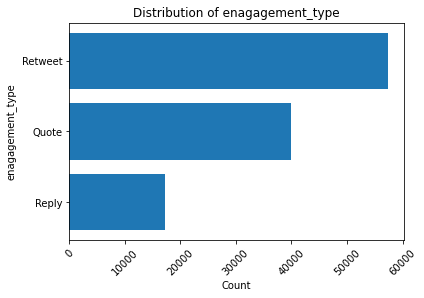

In [60]:
enagagement_type = [c[0] for c in count_tweet_enagagement_type]
counts = [c[1] for c in count_tweet_enagagement_type]

plt.barh(enagagement_type[::-1], counts[::-1])
 
plt.ylabel("enagagement_type")
plt.xlabel("Count")
plt.xticks(rotation=45)
plt.title("Distribution of enagagement_type")
plt.show()

In [61]:
# constants
COUNTRY = 'Singapore'
TOP_RTS_POS_NEG = 5

# 2. Foreign influence: Inferring the influential countries

**Influential countries**: Tweets by non-Singapore based users with a high number of engagements - retweets and quoted tweets, by Singapore users. 

##### Selecting tweets created by non-Singapore based users and known geocoding. 

In [92]:
quoted_sg_tweets = sg_tweets[(sg_tweets['tweet_enagagement_type'] == 'Quote') & 
                             (sg_tweets['quoted_user_geo_coding'] != 'Unknown') & 
                            (sg_tweets['quoted_user_geo_coding'] != 'Singapore')]

rts_sg_tweets = sg_tweets[(sg_tweets['tweet_enagagement_type'] == 'Retweet') & 
                          (sg_tweets['retweeted_user_geo_coding'] != 'Unknown') & 
                          (sg_tweets['retweeted_user_geo_coding'] != 'Singapore')]


##### Merging quoted tweets and retweets

In [93]:
quoted_rts_geo = list(quoted_sg_tweets['quoted_user_geo_coding']) + \
                list(rts_sg_tweets['retweeted_user_geo_coding'])
c_quoted_rts_geo = col.Counter(quoted_rts_geo).most_common()

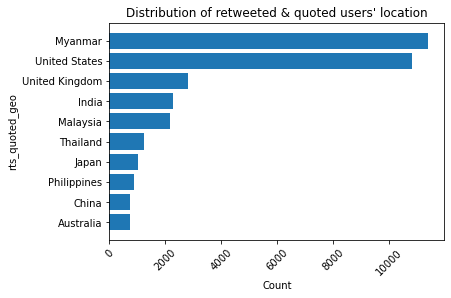

In [94]:
x_top = 10

quoted_rts_geo = [c[0] for c in c_quoted_rts_geo[:x_top]]
counts = [c[1] for c in c_quoted_rts_geo[:x_top]]

plt.barh(quoted_rts_geo[::-1], counts[::-1])
 
plt.ylabel("rts_quoted_geo")
plt.xlabel("Count")
plt.xticks(rotation=45)
plt.title("Distribution of retweeted & quoted users' location")
plt.show()

In [95]:
countries_data = pd.read_csv("data/countries.csv")
countries_data

,Country,Alpha-2 code,Alpha-3 code,Numeric code,Latitude (average),Longitude (average)
0,Afghanistan,"""AF""","""AFG""","""4""","""33""","""65"""
1,Albania,"""AL""","""ALB""","""8""","""41""","""20"""
2,Algeria,"""DZ""","""DZA""","""12""","""28""","""3"""
3,American Samoa,"""AS""","""ASM""","""16""","""-14.3333""","""-170"""
4,Andorra,"""AD""","""AND""","""20""","""42.5""","""1.6"""
...,...,...,...,...,...,...
251,Wallis and Futuna,"""WF""","""WLF""","""876""","""-13.3""","""-176.2"""
252,Western Sahara,"""EH""","""ESH""","""732""","""24.5""","""-13"""
253,Yemen,"""YE""","""YEM""","""887""","""15""","""48"""
254,Zambia,"""ZM""","""ZMB""","""894""","""-15""","""30"""


In [68]:
SINGAPORE_LONG_LAT = countries_data[countries_data['Country'] == 'Singapore']

sg_long = float(SINGAPORE_LONG_LAT.iloc[0]['Longitude (average)'].strip().strip('"'))  #.iloc(0)['Longitude (average)']
sg_lat = float(SINGAPORE_LONG_LAT.iloc[0]['Latitude (average)'].strip().strip('"'))

sg_long, sg_lat

(103.8, 1.3667)

In [78]:
top_influential_countries_data = {
    'country': [],
    'lat': [],
    'long': [],
    'count': [],
    'size': []
}

sum_influence = sum([c[1] for c in top_country_influencer])

for i in top_country_influencer:
    top_influential_countries_data['country'].append(i[0])
    top_influential_countries_data['count'].append(i[1])
    top_influential_countries_data['size'].append(round(i[1]/sum_influence*150, 2))
    country_loc = countries_data[countries_data['Country'] == i[0]]
    top_influential_countries_data['long'].append(float(country_loc.iloc[0]['Longitude (average)'].strip().strip('"')))
    top_influential_countries_data['lat'].append(float(country_loc.iloc[0]['Latitude (average)'].strip().strip('"')))
    

In [79]:
df = pd.DataFrame(data)
pd.DataFrame.to_csv(df, 'data/output/influencers/top_countries.csv')
df

,country,lat,long,count,size
0,Myanmar,22.0,98.0,11400,50.15
1,United States,38.0,-97.0,10804,47.53
2,United Kingdom,54.0,-2.0,2821,12.41
3,India,20.0,77.0,2271,9.99
4,Malaysia,2.5,112.5,2180,9.59
5,Thailand,15.0,100.0,1221,5.37
6,Japan,36.0,138.0,1020,4.49
7,Philippines,13.0,122.0,884,3.89
8,China,35.0,105.0,751,3.30
9,Australia,-27.0,133.0,744,3.27


In [96]:
# saving tweets from influential countries
top_influential_countries = country_data['Country']
top_countries_tweets = sg_tweets[(sg_tweets['retweeted_user_geo_coding'].isin(top_influential_countries))
                                & (sg_tweets['processed_tweet_text'].notna())] \
                        [['retweeted_user_geo_coding', 'processed_tweet_text']]
pd.DataFrame.to_csv(top_countries_tweets, 'data/output/influencers/top_countries_data.csv')

In [84]:
top_countries_tweets

,retweeted_user_geo_coding,processed_tweet_text
7,United States,took daughter kindergarten orientation vaccine...
8,Singapore,wishing singapore happy 56th birthday advance ...
13,United Kingdom,set shot
19,United States,took daughter kindergarten orientation vaccine...
20,India,americas refusal mandate vaccines worst sort w...
...,...,...
181398,United States,#
181399,India,# immanuvel devendrar later took immanuel seka...
181400,Myanmar,/ junta military troops shot civilians husband...
181404,Singapore,glance diagnosed case identified close contact...


# 3. Bursty tweets: Inferring tweets with high intensity of extreme sentiments

**Viral quoted tweets**:
Tweets created between MIN_DATE and MAX_DATE that are (1) highly quoted by count or (2) received an unusual number of endorsements - retweets and favorites

**Bursty tweets**: Viral quoted tweets with high intensity ( >= 80% ) of extreme sentiments (positive and negative sentiments)

### 3.1. Inferring viral quoted tweets

##### Filtering quoted tweets 

In [125]:
tweet_enagagement_quotes = sg_tweets[sg_tweets['tweet_enagagement_type'] == 'Quote']
tweet_enagagement_quotes.shape

(39921, 54)

##### Formating `quoted_tweet_time` and adding `quoted_tweet_date`

In [126]:
tweet_enagagement_quotes['quoted_tweet_time'] = pd.to_datetime(tweet_enagagement_quotes['quoted_tweet_time'], errors='coerce')
tweet_enagagement_quotes = tweet_enagagement_quotes.dropna(subset=['quoted_tweet_time'])
tweet_enagagement_quotes['quoted_tweet_date'] = tweet_enagagement_quotes.quoted_tweet_time.dt.strftime('%Y-%m-%d')

##### Adding `total_engagement` = `quoted_retweet_count` + `quoted_favorite_count`

In [127]:
tweet_enagagement_quotes['total_engagement'] = tweet_enagagement_quotes['quoted_retweet_count']  + tweet_enagagement_quotes['quoted_favorite_count'] 

tweet_enagagement_quotes[['quoted_tweet_id', 'total_engagement']] = tweet_enagagement_quotes[['quoted_tweet_id', 'total_engagement']].astype(int)
tweet_enagagement_quotes = tweet_enagagement_quotes.loc[:, ~tweet_enagagement_quotes.columns.str.contains('^Unnamed')]

##### (1) Filtering quoted tweets created between `MIN_DATE` and `MAX_DATE`

In [128]:
quoted_tweets = tweet_enagagement_quotes[(tweet_enagagement_quotes['quoted_tweet_date'].between(MIN_DATE, MAX_DATE, inclusive=True))]

##### (2) Filtering highly quoted by count 

In [ ]:
# count of RTs
c_quoted = quoted_tweets.value_counts(subset=['quoted_tweet_id']).reset_index(name='local_count').sort_values('local_count', ascending=False)
# top RTs by count
quoted_qids_by_count = list(c_quoted[:10]['quoted_tweet_id'])

##### (3) Filtering anomalous quoted tweets - with an unusual number of engagements.

In [129]:
# top quoted tweets by spike in engagements
grouped_sorted_date = quoted_tweets.groupby(['quoted_tweet_id', 'quoted_tweet_date']).apply(pd.DataFrame.sort_values, 'quoted_tweet_date').reset_index(drop=True)
max_grouped_sorted_date = grouped_sorted_date.groupby(['quoted_tweet_id', 'quoted_tweet_date'])['total_engagement'].max().reset_index()
max_grouped_sorted_date['delta_engagement'] = max_grouped_sorted_date.groupby(['quoted_tweet_id'])['total_engagement'].diff().fillna(0).astype(int)
spike = max_grouped_sorted_date.groupby('quoted_tweet_id').nth(0)
spike = list(spike[spike['delta_engagement'] > 300].reset_index()['quoted_tweet_id'])

##### Get viral RTs by count and spiky engagements

In [130]:
viral_quoted_tweets = quoted_tweets[quoted_tweets['quoted_tweet_id'].isin(quoted_qids_by_count + spike)]

##### get data for delta and cumulative graphs


In [ ]:
grouped_sorted_date = viral_quoted_tweets.groupby(['quoted_tweet_id', 'tweet_date', 'quoted_user_screenname']).apply(pd.DataFrame.sort_values, 'tweet_date').reset_index(drop=True)
max_grouped_sorted_date = grouped_sorted_date.groupby(['quoted_tweet_id', 'tweet_date', 'quoted_user_screenname'])['total_engagement'].max().reset_index()
max_grouped_sorted_date['delta_engagement'] = max_grouped_sorted_date.groupby(['quoted_user_screenname'])['total_engagement'].diff().fillna(0).astype(int)

### 3.2. Sentiment analysis of the viral quoted tweets

In [131]:
quoted_by_sentiment = viral_quoted_tweets.groupby(['quoted_tweet_id', 'tweet_sentiment']).size()\
                        .unstack(fill_value=0).reset_index()
quoted_by_sentiment

In [132]:
quoted_by_sentiment['pos_count'] = quoted_by_sentiment['positive'] / (quoted_by_sentiment['positive'] + 
                                                                      quoted_by_sentiment['negative'] + 
                                                                      quoted_by_sentiment['neutral'])*100 


quoted_by_sentiment['neg_count'] = quoted_by_sentiment['negative'] / (quoted_by_sentiment['positive'] + 
                                                                      quoted_by_sentiment['negative'] + 
                                                                      quoted_by_sentiment['neutral'])*100 

### 3.3. Inferring viral quoted tweets with extreme intensity of sentiments

In [133]:
most_spread_quoted_by_sentiment_with_rate = quoted_by_sentiment[(quoted_by_sentiment['pos_count'] >= 80) | (quoted_by_sentiment['neg_count'] >= 80)]
most_spread_quoted_by_sentiment_with_rate

tweet_sentiment,quoted_tweet_id,negative,neutral,positive,pos_count,neg_count
0,1424662560909922304,3,7,96,90.566038,2.830189
8,1438395703185735680,252,26,8,2.797203,88.111888
9,1439236328772669440,85,7,0,0.000000,92.391304


In [113]:
most_spread_quoted_ids = list(most_spread_quoted_by_sentiment_with_rate['quoted_tweet_id'])
most_spread_quoted_ids

[1424662560909922304, 1438395703185735680, 1439236328772669440]

In [115]:
most_spread_quoted_info = viral_quoted_tweets[viral_quoted_tweets['quoted_tweet_id'].isin(most_spread_quoted_ids)]

In [116]:
most_spread_quoted_info = most_spread_quoted_info[['quoted_tweet_id', 'quoted_tweet_text', 'quoted_user_screenname', 'quoted_user_geo_coding', 'quoted_tweet_date', 'quoted_user_verified', 'total_engagement']]

In [117]:
most_spread_quoted_info = most_spread_quoted_info.loc[most_spread_quoted_info.groupby(["quoted_tweet_id"])["total_engagement"].idxmax()]  

In [118]:
final_most_spread_quoted = most_spread_quoted_info.merge(most_spread_quoted_by_sentiment_with_rate, on="quoted_tweet_id", how = 'inner')
final_most_spread_quoted.shape

(3, 12)

In [119]:
final_most_spread_quoted.drop(['negative', 'positive', 'neutral'], 1, inplace=True) 

##### Adding `spread_type` and `spread_rate`. 80% > positivity spread and 80% > negativity spread

In [120]:
final_most_spread_quoted['spread_type'] = ['positive' if spread_rate >= 80 else 'negative' for spread_rate in final_most_spread_quoted['pos_count']]
final_most_spread_quoted['spread_rate'] = [round(row['pos_count'], 2) if row['spread_type'] == 'positive' 
                                           else round(row['neg_count'], 2) for _, row in final_most_spread_quoted.iterrows()]

In [121]:
final_most_spread_quoted.drop(['pos_count', 'neg_count'], 1, inplace=True) 
pd.DataFrame.to_csv(final_most_spread_quoted, 'data/output/quoted/sentiment_spread.csv')

In [ ]:
# popular_quoted_first = viral_quoted_tweets[['tweet_text', 'tweet_sentiment', 'quoted_user_screenname', 'quoted_user_verified', 'quoted_user_geo_coding', 'quoted_tweet_id']].groupby('quoted_tweet_id').nth(0)
# dfs = [popular_quoted_first]
# popular_quoted_data = ft.reduce(lambda left,right: pd.merge(left,right,on='quoted_tweet_id'), dfs)

# quoted_sentiments =  viral_quoted_tweets[['user_screenname_x', 'user_geo_coding', 'tweet_text', 'tweet_sentiment', 
#                 'quoted_tweet_sentiment', 'quoted_tweet_text', 'quoted_user_screenname', 'quoted_user_geo_coding']]

# quoted_tweets_with_sentiment = sg_tweets[(sg_tweets['tweet_enagagement_type'] == 'Quote') & (sg_tweets['quoted_tweet_sentiment'].notna())]
# sentiments = ['positive', 'negative', 'neutral']
# sentiments_comb = it.product(sentiments, sentiments)
# sentiments_comb = list(sentiments_comb)
# sentiments_comb

## Retweets - Popular tweets in SG and global influence

In [13]:
tweet_enagagement_retweet = sg_tweets[sg_tweets['tweet_enagagement_type'] == 'Retweet']

In [16]:
## retweet time processing
tweet_enagagement_retweet['retweeted_tweet_time'] = pd.to_datetime(tweet_enagagement_retweet['retweeted_tweet_time'], errors='coerce')
tweet_enagagement_retweet = tweet_enagagement_retweet.dropna(subset=['retweeted_tweet_time'])
tweet_enagagement_retweet['retweeted_tweet_date'] = tweet_enagagement_retweet.retweeted_tweet_time.dt.strftime('%Y-%m-%d')

In [25]:
rts_geo = tweet_enagagement_retweet['retweeted_user_geo_coding']

c_rts_geo = col.Counter(rts_geo).most_common()
# c_rts_geo

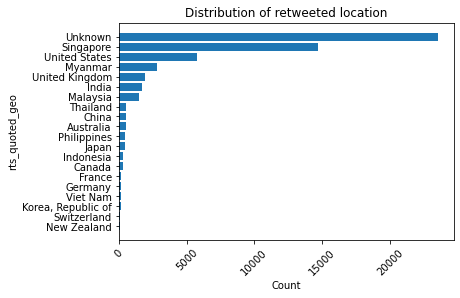

In [18]:
x_top = 20

rts_geo = [c[0] for c in c_rts_geo[:x_top]]
counts = [c[1] for c in c_rts_geo[:x_top]]

plt.barh(rts_geo[::-1], counts[::-1])
 
plt.ylabel("rts_quoted_geo")
plt.xlabel("Count")
plt.xticks(rotation=45)
plt.title("Distribution of retweeted location")
plt.show()


In [32]:
tweet_enagagement_retweet['total_engagement'] = tweet_enagagement_retweet['retweeted_retweet_count']  + tweet_enagagement_retweet['retweeted_favorite_count'] 
tweet_enagagement_retweet[['retweeted_tweet_id', 'total_engagement']] = tweet_enagagement_retweet[['retweeted_tweet_id', 'total_engagement']].astype(int)

tweet_enagagement_retweet = tweet_enagagement_retweet.loc[:, ~tweet_enagagement_retweet.columns.str.contains('^Unnamed')]

## 1. Local News -- creator SG user

In [33]:
neg_local_retweet = tweet_enagagement_retweet[(tweet_enagagement_retweet['tweet_sentiment'] == 'negative') & \
                                                    (tweet_enagagement_retweet['retweeted_user_geo_coding'] ==  COUNTRY) & \
                                                    (tweet_enagagement_retweet['retweeted_tweet_date'].between(MIN_DATE, MAX_DATE, inclusive=True))]

pos_local_retweet = tweet_enagagement_retweet[(tweet_enagagement_retweet['tweet_sentiment'] == 'positive') & \
                                                    (tweet_enagagement_retweet['retweeted_user_geo_coding'] ==  COUNTRY) & \
                                                    (tweet_enagagement_retweet['retweeted_tweet_date'].between(MIN_DATE, MAX_DATE, inclusive=True))]

all_local_retweet = tweet_enagagement_retweet[(tweet_enagagement_retweet['retweeted_user_geo_coding'] ==  COUNTRY) & \
                                                    (tweet_enagagement_retweet['retweeted_tweet_date'].between(MIN_DATE, MAX_DATE, inclusive=True))]

#### Negative Local 

In [38]:
neg_local_retweet.value_counts(subset=['retweeted_tweet_id']).reset_index(name='local_count')

,retweeted_tweet_id,local_count
0,1440562070898962432,100
1,1424598213856620288,68
2,1438395703185735680,35
3,1434725178240499712,31
4,1425698659115491328,31
...,...,...
1779,1428893502033649664,1
1780,1428891365992144896,1
1781,1428844814909333504,1
1782,1428841803126435840,1


In [41]:
# count of RTs
c_neg_local_retweet = neg_local_retweet.value_counts(subset=['retweeted_tweet_id']).reset_index(name='local_count').sort_values('local_count', ascending=False)

# top RTs by count
neg_local_rtids_by_count = list(c_neg_local_retweet[:TOP_RTS_POS_NEG]['retweeted_tweet_id'])

# top RTs by spike in engagements
grouped_sorted_date = neg_local_retweet.groupby(['retweeted_tweet_id', 'tweet_date']).apply(pd.DataFrame.sort_values, 'tweet_date').reset_index(drop=True)
max_grouped_sorted_date = grouped_sorted_date.groupby(['retweeted_tweet_id', 'tweet_date'])['total_engagement'].max().reset_index()
max_grouped_sorted_date['delta_engagement'] = max_grouped_sorted_date.groupby(['retweeted_tweet_id'])['total_engagement'].diff().fillna(0).astype(int)
spike = max_grouped_sorted_date.groupby('retweeted_tweet_id').nth(1)
spike = list(spike[spike['delta_engagement'] > 600].reset_index()['retweeted_tweet_id'])

# get viral RTs by count and spiky engagements
viral_neg_local_rts = neg_local_retweet[neg_local_retweet['retweeted_tweet_id'].isin(set(neg_local_rtids_by_count + spike))]

# get data for delta and cumulative graphs
grouped_sorted_date = viral_neg_local_rts.groupby(['retweeted_tweet_id', 'tweet_date', 'retweeted_user_screenname']).apply(pd.DataFrame.sort_values, 'tweet_date').reset_index(drop=True)
max_grouped_sorted_date = grouped_sorted_date.groupby(['retweeted_tweet_id', 'tweet_date', 'retweeted_user_screenname'])['total_engagement'].max().reset_index()
max_grouped_sorted_date['delta_engagement'] = max_grouped_sorted_date.groupby(['retweeted_tweet_id'])['total_engagement'].diff().fillna(0).astype(int)

pd.DataFrame.to_csv(max_grouped_sorted_date, 'data/output/rts/local/neg_local_rts_trend.csv')

In [42]:
viral_neg_local_rts['tweet_text_'] = [re.sub("RT @[A-Z_a-z_0-9:]+","", txt).strip() for txt in viral_neg_local_rts['tweet_text'] ]

details_viral_neg_local_rts = viral_neg_local_rts[['tweet_text_', 'tweet_date', 'tweet_sentiment','retweeted_user_screenname', 'total_engagement',
                                                   'retweeted_user_verified', 'retweeted_tweet_id']] \
                                                .groupby('retweeted_tweet_id') \
                                                .apply(pd.DataFrame.sort_values, 'total_engagement') \
                                                .reset_index(drop=True).groupby('retweeted_tweet_id').last().reset_index()


details_viral_neg_local_rts = details_viral_neg_local_rts.loc[:, ~details_viral_neg_local_rts.columns.str.contains('^Unnamed')]

details_viral_neg_local_rts

k = px.colors.qualitative.Pastel[:details_viral_neg_local_rts.shape[0]]
details_viral_neg_local_rts['color'] = k

pd.DataFrame.to_csv(details_viral_neg_local_rts, 'data/output/rts/local/neg_local_rts_info.csv')

#### Positive Local 

In [43]:
# count of RTs
c_pos_local_retweet = pos_local_retweet.value_counts(subset=['retweeted_tweet_id']).reset_index(name='local_count').sort_values('local_count', ascending=False)

# top RTs by count
pos_local_rtids_by_count = list(c_pos_local_retweet[:TOP_RTS_POS_NEG]['retweeted_tweet_id'])

# top RTs by spike in engagements
grouped_sorted_date = pos_local_retweet.groupby(['retweeted_tweet_id', 'tweet_date']).apply(pd.DataFrame.sort_values, 'tweet_date').reset_index(drop=True)
max_grouped_sorted_date = grouped_sorted_date.groupby(['retweeted_tweet_id', 'tweet_date'])['total_engagement'].max().reset_index()
max_grouped_sorted_date['delta_engagement'] = max_grouped_sorted_date.groupby(['retweeted_tweet_id'])['total_engagement'].diff().fillna(0).astype(int)
spike = max_grouped_sorted_date.groupby('retweeted_tweet_id').nth(1)
spike = list(spike[spike['delta_engagement'] >= 1500].reset_index()['retweeted_tweet_id'])

# print("By count: ", len(pos_local_rtids_by_count))
# print("By spike: ", len(spike))
# get viral RTs by count and spiky engagements
viral_pos_local_rts = pos_local_retweet[pos_local_retweet['retweeted_tweet_id'].isin(set(pos_local_rtids_by_count + spike))]

# get data for delta and cumulative graphs
grouped_sorted_date = viral_pos_local_rts.groupby(['retweeted_tweet_id', 'tweet_date', 'retweeted_user_screenname']).apply(pd.DataFrame.sort_values, 'tweet_date').reset_index(drop=True)
max_grouped_sorted_date = grouped_sorted_date.groupby(['retweeted_tweet_id', 'tweet_date', 'retweeted_user_screenname'])['total_engagement'].max().reset_index()
max_grouped_sorted_date['delta_engagement'] = max_grouped_sorted_date.groupby(['retweeted_tweet_id'])['total_engagement'].diff().fillna(0).astype(int)

pd.DataFrame.to_csv(max_grouped_sorted_date, 'data/output/rts/local/pos_local_rts_trend.csv')



In [44]:
viral_pos_local_rts['tweet_text_'] = [re.sub("RT @[A-Z_a-z_0-9:]+","", txt).strip() for txt in viral_pos_local_rts['tweet_text'] ]

details_viral_pos_local_rts = viral_pos_local_rts[['tweet_text_', 'tweet_date', 'tweet_sentiment', 'retweeted_user_screenname', 'total_engagement',
                                                   'retweeted_user_verified', 'retweeted_tweet_id']] \
                                                .groupby('retweeted_tweet_id') \
                                                .apply(pd.DataFrame.sort_values, 'total_engagement') \
                                                .reset_index(drop=True).groupby('retweeted_tweet_id').last().reset_index()


details_viral_pos_local_rts = details_viral_pos_local_rts.loc[:, ~details_viral_pos_local_rts.columns.str.contains('^Unnamed')]

details_viral_pos_local_rts


# details_viral_pos_local_rts.index.name = 'index'

k = px.colors.qualitative.Pastel[:details_viral_pos_local_rts.shape[0]]
details_viral_pos_local_rts['color'] = k


pd.DataFrame.to_csv(details_viral_pos_local_rts, 'data/output/rts/local/pos_local_rts_info.csv')

## 2. Global News -- creator SG user

In [45]:
neg_global_retweet = tweet_enagagement_retweet[(tweet_enagagement_retweet['tweet_sentiment'] == 'negative') & \
                                                    (tweet_enagagement_retweet['retweeted_user_geo_coding'] !=  COUNTRY) & \
                                                    (tweet_enagagement_retweet['retweeted_tweet_date'].between(MIN_DATE, MAX_DATE, inclusive=True))]

pos_global_retweet = tweet_enagagement_retweet[(tweet_enagagement_retweet['tweet_sentiment'] == 'positive') & \
                                                    (tweet_enagagement_retweet['retweeted_user_geo_coding'] !=  COUNTRY) & \
                                                    (tweet_enagagement_retweet['retweeted_tweet_date'].between(MIN_DATE, MAX_DATE, inclusive=True))]

all_global_retweet = tweet_enagagement_retweet[(tweet_enagagement_retweet['retweeted_user_geo_coding'] !=  COUNTRY) & \
                                               (tweet_enagagement_retweet['retweeted_tweet_date'].between(MIN_DATE, MAX_DATE, inclusive=True))]

#### Positive Global 

In [46]:
# count of RTs
c_neg_global_retweet = neg_global_retweet.value_counts(subset=['retweeted_tweet_id']) \
                        .reset_index(name='global_count').sort_values('global_count', ascending=False)

# top RTs by count
neg_global_rtids_by_count = list(c_neg_global_retweet[:TOP_RTS_POS_NEG]['retweeted_tweet_id'])

# top RTs by spike in engagements
grouped_sorted_date = neg_global_retweet.groupby(['retweeted_tweet_id', 'tweet_date']).apply(pd.DataFrame.sort_values, 'tweet_date').reset_index(drop=True)
max_grouped_sorted_date = grouped_sorted_date.groupby(['retweeted_tweet_id', 'tweet_date'])['total_engagement'].max().reset_index()
max_grouped_sorted_date['delta_engagement'] = max_grouped_sorted_date.groupby(['retweeted_tweet_id'])['total_engagement'].diff().fillna(0).astype(int)
spike = max_grouped_sorted_date.groupby('retweeted_tweet_id').nth(1)
spike = list(spike[spike['delta_engagement'] > 240000].reset_index()['retweeted_tweet_id'])

# get viral RTs by count and spiky engagements
viral_neg_global_rts = neg_global_retweet[neg_global_retweet['retweeted_tweet_id'].isin(set(neg_global_rtids_by_count + spike))]

# get data for delta and cumulative graphs
grouped_sorted_date = viral_neg_global_rts.groupby(['retweeted_tweet_id', 'tweet_date', 'retweeted_user_screenname']).apply(pd.DataFrame.sort_values, 'tweet_date').reset_index(drop=True)
max_grouped_sorted_date = grouped_sorted_date.groupby(['retweeted_tweet_id', 'tweet_date', 'retweeted_user_screenname'])['total_engagement'].max().reset_index()
max_grouped_sorted_date['delta_engagement'] = max_grouped_sorted_date.groupby(['retweeted_tweet_id'])['total_engagement'].diff().fillna(0).astype(int)

pd.DataFrame.to_csv(max_grouped_sorted_date, 'data/output/rts/global/neg_global_rts_trend.csv')

In [47]:
viral_neg_global_rts['tweet_text_'] = [re.sub("RT @[A-Z_a-z_0-9:]+","", txt).strip() for txt in viral_neg_global_rts['tweet_text'] ]

details_viral_neg_global_rts = viral_neg_global_rts[['tweet_text_', 'tweet_date', 'tweet_sentiment','retweeted_user_screenname', 'total_engagement',
                                                   'retweeted_user_verified', 'retweeted_tweet_id']] \
                                                .groupby('retweeted_tweet_id') \
                                                .apply(pd.DataFrame.sort_values, 'total_engagement') \
                                                .reset_index(drop=True).groupby('retweeted_tweet_id').last().reset_index()


details_viral_neg_global_rts = details_viral_neg_global_rts.loc[:, ~details_viral_neg_global_rts.columns.str.contains('^Unnamed')]
k = px.colors.qualitative.Pastel[:details_viral_neg_global_rts.shape[0]]

details_viral_neg_global_rts['color'] = k

pd.DataFrame.to_csv(details_viral_neg_global_rts, 'data/output/rts/global/neg_global_rts_info.csv')

#### Negative Global

In [48]:
# count of RTs
c_pos_global_retweet = pos_global_retweet.value_counts(subset=['retweeted_tweet_id']) \
                        .reset_index(name='global_count').sort_values('global_count', ascending=False)

# top RTs by count
pos_global_rtids_by_count = list(c_pos_global_retweet[:TOP_RTS_POS_NEG]['retweeted_tweet_id'])

# top RTs by spike in engagements
grouped_sorted_date = pos_global_retweet.groupby(['retweeted_tweet_id', 'tweet_date']).apply(pd.DataFrame.sort_values, 'tweet_date').reset_index(drop=True)
max_grouped_sorted_date = grouped_sorted_date.groupby(['retweeted_tweet_id', 'tweet_date'])['total_engagement'].max().reset_index()
max_grouped_sorted_date['delta_engagement'] = max_grouped_sorted_date.groupby(['retweeted_tweet_id'])['total_engagement'].diff().fillna(0).astype(int)
spike = max_grouped_sorted_date.groupby('retweeted_tweet_id').nth(1)
spike = list(spike[spike['delta_engagement'] > 280000].reset_index()['retweeted_tweet_id'])

# get viral RTs by count and spiky engagements
viral_pos_global_rts = pos_global_retweet[pos_global_retweet['retweeted_tweet_id'].isin(set(pos_global_rtids_by_count + spike))]

# get data for delta and cumulative graphs
grouped_sorted_date = viral_pos_global_rts.groupby(['retweeted_tweet_id', 'tweet_date', 'retweeted_user_screenname']).apply(pd.DataFrame.sort_values, 'tweet_date').reset_index(drop=True)
max_grouped_sorted_date = grouped_sorted_date.groupby(['retweeted_tweet_id', 'tweet_date', 'retweeted_user_screenname'])['total_engagement'].max().reset_index()
max_grouped_sorted_date['delta_engagement'] = max_grouped_sorted_date.groupby(['retweeted_tweet_id'])['total_engagement'].diff().fillna(0).astype(int)

pd.DataFrame.to_csv(max_grouped_sorted_date, 'data/output/rts/global/pos_global_rts_trend.csv')

In [49]:
viral_pos_global_rts['tweet_text_'] = [re.sub("RT @[A-Z_a-z_0-9:]+","", txt).strip() for txt in viral_pos_global_rts['tweet_text'] ]

details_viral_pos_global_rts = viral_pos_global_rts[['tweet_text_', 'tweet_date', 'tweet_sentiment','retweeted_user_screenname', 'total_engagement',
                                                   'retweeted_user_verified', 'retweeted_tweet_id']] \
                                                .groupby('retweeted_tweet_id') \
                                                .apply(pd.DataFrame.sort_values, 'total_engagement') \
                                                .reset_index(drop=True).groupby('retweeted_tweet_id').last().reset_index()


details_viral_pos_global_rts = details_viral_pos_global_rts.loc[:, ~details_viral_pos_global_rts.columns.str.contains('^Unnamed')]
k = px.colors.qualitative.Pastel[:details_viral_pos_global_rts.shape[0]]

details_viral_pos_global_rts['color'] = k

pd.DataFrame.to_csv(details_viral_pos_global_rts, 'data/output/rts/global/pos_global_rts_info.csv')

## Sentiment Analysis 

In [63]:
# from functools import reduce

popular_quoted_first = viral_quoted_tweets[['tweet_text', 'tweet_sentiment', 'quoted_user_screenname', 'quoted_user_verified', 'quoted_user_geo_coding', 'quoted_tweet_id']].groupby('quoted_tweet_id').nth(0)

dfs = [popular_quoted_first]

popular_quoted_data = ft.reduce(lambda left,right: pd.merge(left,right,on='quoted_tweet_id'), dfs)
# popular_quoted_data

NameError: name 'viral_quoted_tweets' is not defined

In [ ]:
quoted_sentiments =  viral_quoted_tweets[['user_screenname_x', 'user_geo_coding', 'tweet_text', 'tweet_sentiment', 
                'quoted_tweet_sentiment', 'quoted_tweet_text', 'quoted_user_screenname', 'quoted_user_geo_coding']]

In [ ]:
quoted_tweets_with_sentiment = sg_tweets[(sg_tweets['tweet_enagagement_type'] == 'Quote') & (sg_tweets['quoted_tweet_sentiment'].notna())]
sentiments = ['positive', 'negative', 'neutral']
sentiments_comb = it.product(sentiments, sentiments)
sentiments_comb = list(sentiments_comb)
sentiments_comb

In [ ]:
# sentiments of viral quoted tweets


quoted_by_sentiment = viral_quoted_tweets.groupby(['quoted_tweet_id', 'tweet_sentiment']).size()\
                        .unstack(fill_value=0).reset_index()

# viral_quoted_tweets.groupby('quoted_tweet_id').apply(pd.DataFrame.count_values, 'tweet_sentiment') \
#                                             .reset_index(drop=True)#.groupby('retweeted_tweet_id').last().reset_index()
quoted_by_sentiment

## Good stuff: 80% > positivity spread and 80% > negativity spread

In [64]:
most_spread_quoted_by_sentiment_with_rate = quoted_by_sentiment[(quoted_by_sentiment['pos_count'] >= 80) | (quoted_by_sentiment['neg_count'] >= 80)]
most_spread_quoted_by_sentiment_with_rate

NameError: name 'quoted_by_sentiment' is not defined

In [ ]:
most_spread_quoted_ids = list(most_spread_quoted_by_sentiment_with_rate['quoted_tweet_id'])
most_spread_quoted_ids

In [ ]:
most_spread_quoted_info = viral_quoted_tweets[viral_quoted_tweets['quoted_tweet_id'].isin(most_spread_quoted_ids)]
most_spread_quoted_info.columns

In [ ]:
most_spread_quoted_info = most_spread_quoted_info[['quoted_tweet_id', 'quoted_tweet_text', 'quoted_user_screenname', 'quoted_user_geo_coding', 'quoted_tweet_date', 'quoted_user_verified', 'total_engagement']]

In [ ]:
most_spread_quoted_info = most_spread_quoted_info.loc[most_spread_quoted_info.groupby(["quoted_tweet_id"])["total_engagement"].idxmax()]  

In [ ]:
final_most_spread_quoted = most_spread_quoted_info.merge(most_spread_quoted_by_sentiment_with_rate, on="quoted_tweet_id", how = 'inner')
final_most_spread_quoted.shape

In [ ]:
final_most_spread_quoted.drop(['negative', 'positive', 'neutral'], 1, inplace=True) 

In [ ]:
final_most_spread_quoted['spread_type'] = ['positive' if spread_rate >= 80 else 'negative' for spread_rate in final_most_spread_quoted['pos_count']]

In [ ]:
final_most_spread_quoted['spread_rate'] = [round(row['pos_count'], 2) if row['spread_type'] == 'positive' else round(row['neg_count'], 2) for _, row in final_most_spread_quoted.iterrows()]

In [ ]:
final_most_spread_quoted.drop(['pos_count', 'neg_count'], 1, inplace=True) 

In [ ]:
final_most_spread_quoted

In [ ]:
most_spread_quoted_info[most_spread_quoted_info['quoted_tweet_id'] == 1438395703185735680]['total_engagement'].max()

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
test_q = 1438395703185735680
print(tweet_enagagement_quotes[tweet_enagagement_quotes['quoted_tweet_id'] == test_q][['quoted_tweet_sentiment', 'quoted_tweet_text']].head(1))
tweet_enagagement_quotes[tweet_enagagement_quotes['quoted_tweet_id'] == test_q].value_counts(subset=['tweet_sentiment']).reset_index(name='count')


In [ ]:
print(list(tweet_enagagement_quotes[tweet_enagagement_quotes['quoted_tweet_id'] == test_q]['quoted_tweet_text'])[0])


# Another version 

In [5]:
TOP_RTS = 8

pos_tweet_enagagement_retweet = sg_tweets[(sg_tweets['tweet_enagagement_type'] == 'Retweet') & (sg_tweets['tweet_sentiment'] == 'positive')]
pos_tweet_enagagement_retweet['retweeted_tweet_time'] = pd.to_datetime(pos_tweet_enagagement_retweet['retweeted_tweet_time'], errors='coerce')
pos_tweet_enagagement_retweet = pos_tweet_enagagement_retweet.dropna(subset=['retweeted_tweet_time'])
pos_tweet_enagagement_retweet['retweeted_tweet_date'] = pos_tweet_enagagement_retweet.retweeted_tweet_time.dt.strftime('%Y-%m-%d')


pos_tweet_enagagement_retweet = pos_tweet_enagagement_retweet[pos_tweet_enagagement_retweet['retweeted_tweet_date'].between(MIN_DATE, MAX_DATE, inclusive=True)]
pos_local_rts = pos_tweet_enagagement_retweet.value_counts(subset=['retweeted_tweet_id']).reset_index(name='local_count').sort_values('local_count', ascending=False)
pos_local_rts['retweeted_tweet_id'] = pos_local_rts['retweeted_tweet_id'].apply(int).apply(str)
pos_local_rts = pos_local_rts[:20]
pos_local_rts = [int(i) for i in list(pos_local_rts['retweeted_tweet_id'])]

pos_local_rts = sg_tweets[sg_tweets['retweeted_tweet_id'].isin(pos_local_rts)]

NameError: name 'sg_tweets' is not defined

#### Negative tweets circulating the most

In [ ]:
TOP_RTS = 10
neg_tweet_enagagement_retweet = sg_tweets[(sg_tweets['tweet_enagagement_type'] == 'Retweet') & (sg_tweets['tweet_sentiment'] == 'negative')]
neg_tweet_enagagement_retweet['retweeted_tweet_time'] = pd.to_datetime(neg_tweet_enagagement_retweet['retweeted_tweet_time'], errors='coerce')
neg_tweet_enagagement_retweet = neg_tweet_enagagement_retweet.dropna(subset=['retweeted_tweet_time'])
neg_tweet_enagagement_retweet['retweeted_tweet_date'] = neg_tweet_enagagement_retweet.retweeted_tweet_time.dt.strftime('%Y-%m-%d')

In [ ]:
neg_tweet_enagagement_retweet = neg_tweet_enagagement_retweet[neg_tweet_enagagement_retweet['retweeted_tweet_date'].between(MIN_DATE, MAX_DATE, inclusive=True)]
neg_local_rts = neg_tweet_enagagement_retweet.value_counts(subset=['retweeted_tweet_id']).reset_index(name='local_count').sort_values('local_count', ascending=False)
neg_local_rts['retweeted_tweet_id'] = neg_local_rts['retweeted_tweet_id'].apply(int).apply(str)
neg_local_rts = neg_local_rts[:10]
neg_top_rts_list = [int(i) for i in list(neg_local_rts['retweeted_tweet_id'])]

neg_popular_rts = sg_tweets[sg_tweets['retweeted_tweet_id'].isin(neg_top_rts_list)]
neg_popular_rts

In [ ]:
neg_global_rts = tw_data[tw_data['retweeted_tweet_id'].isin(neg_top_rts_list)]
neg_global_rts = neg_global_rts.value_counts(subset=['retweeted_tweet_id']).reset_index(name='global_count').sort_values('global_count', ascending=False)
neg_global_rts

In [ ]:
neg_global_rts.sort_values(by='retweeted_tweet_id')['global_count'] - neg_local_rts.sort_values(by='retweeted_tweet_id')['local_count']

In [ ]:
#### General RTs

In [ ]:
gen_tweet_enagagement_retweet = sg_tweets[(sg_tweets['tweet_enagagement_type'] == 'Retweet')]
gen_tweet_enagagement_retweet['retweeted_tweet_time'] = pd.to_datetime(gen_tweet_enagagement_retweet['retweeted_tweet_time'], errors='coerce')
gen_tweet_enagagement_retweet = gen_tweet_enagagement_retweet.dropna(subset=['retweeted_tweet_time'])
gen_tweet_enagagement_retweet['retweeted_tweet_date'] = gen_tweet_enagagement_retweet.retweeted_tweet_time.dt.strftime('%Y-%m-%d')

In [ ]:
gen_tweet_enagagement_retweet = gen_tweet_enagagement_retweet[gen_tweet_enagagement_retweet['retweeted_tweet_date'].between(MIN_DATE, MAX_DATE, inclusive=True)]
genral_local_rts = gen_tweet_enagagement_retweet.value_counts(subset=['retweeted_tweet_id']).reset_index(name='local_count').sort_values('local_count', ascending=False)
genral_local_rts['retweeted_tweet_id'] = genral_local_rts['retweeted_tweet_id'].apply(int).apply(str)
genral_local_rts = genral_local_rts[:10]
genral_local_rts_list = [int(i) for i in list(genral_local_rts['retweeted_tweet_id'])]
genral_local_rts_ = sg_tweets[sg_tweets['retweeted_tweet_id'].isin(genral_local_rts_list)]

In [ ]:
global_rts = tw_data[tw_data['retweeted_tweet_id'].isin(genral_local_rts_list)]
global_rts = global_rts.value_counts(subset=['retweeted_tweet_id']).reset_index(name='global_count').sort_values('global_count', ascending=False)
global_rts

In [ ]:
popular_rts['engagement_counts'] = popular_rts['retweeted_favorite_count'].apply(int) + popular_rts['retweeted_retweet_count'].apply(int)
popular_rts['retweeted_tweet_id'] = popular_rts['retweeted_tweet_id'].apply(int).apply(str)
popular_rts['retweeted_user_geo_coding'].fillna(value='Unknown', inplace=True)

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import math

hover_text = []
bubble_size = []

for index, row in popular_rts.iterrows():
    hover_text.append(('Country: {country}<br>'+
                      'Engagement counts: {engagement_counts}<br>'
                      ).format(country=row['retweeted_user_geo_coding'].split('|')[0],
                                engagement_counts=row['engagement_counts']))
    bubble_size.append(math.sqrt(row['engagement_counts']))

popular_rts['hover_text'] = hover_text
popular_rts['size'] = bubble_size
sizeref = 2.*max(popular_rts['size'])/(100**2)

# Dictionary with dataframes for each continent
rts_names = top_rts#['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']
rt_data = {rtid:popular_rts.query("retweeted_tweet_id == '%s'" %rtid)
                              for rtid in rts_names}
# Create figure
fig = go.Figure()

for rtid, rt in rt_data.items():
    fig.add_trace(go.Scatter(
        x=rt['tweet_date'], y=rt['engagement_counts'],
        name=rtid, text=rt['hover_text'],
        marker_size=rt['size'],
        ))

# Tune marker appearance and layout
fig.update_traces(mode='markers', marker=dict(sizemode='area', sizeref=sizeref, line_width=2))

fig.update_layout(
    template="plotly_white",
    showlegend=True, 
    title="Most retweeted tweets' propagation across days",
    xaxis=dict(
        title="",
#         gridcolor='white',
#         type='log',
        gridwidth=1,
    ),
    yaxis=dict(
        title="Users' engagement (RTs + Favorites)",
        gridwidth=1,
    )
)
fig.show()

In [ ]:
from functools import reduce
popular_rts_first = popular_rts[['tweet_text', 'tweet_sentiment', 'retweeted_user_screenname', 'retweeted_user_verified', 'retweeted_user_geo_coding', 'retweeted_tweet_id']].groupby('retweeted_tweet_id').nth(0)
dfs = [popular_rts_first, local_rts, global_rts]
popular_rts_data = reduce(lambda left,right: pd.merge(left,right,on='retweeted_tweet_id'), dfs)

## Quoted - Popular tweets in SG and global influence

In [ ]:
tweet_enagagement_quote = sg_tweets[sg_tweets['tweet_enagagement_type'] == 'Quote']


In [ ]:
TOP_QUOTES = 8
local_quoted = tweet_enagagement_quote.value_counts(subset=['quoted_tweet_id']).reset_index(name='local_count').sort_values('local_count', ascending=False)

local_quoted['quoted_tweet_id'] = local_quoted['quoted_tweet_id'].apply(int).apply(str)

local_quoted = local_quoted[:TOP_QUOTES]
top_quoted = [int(i) for i in list(local_quoted['quoted_tweet_id'])]
local_quoted

In [ ]:
popular_quoted = tweet_enagagement_quote[tweet_enagagement_quote['quoted_tweet_id'].isin(top_quoted)]

In [ ]:
global_quoted = tw_data[tw_data['quoted_tweet_id'].isin(top_quoted)]
global_quoted = global_quoted.value_counts(subset=['quoted_tweet_id']).reset_index(name='global_count').sort_values('global_count', ascending=False)
global_quoted['quoted_tweet_id'] = global_quoted['quoted_tweet_id'].apply(int).apply(str)
global_quoted

In [ ]:
popular_quoted['engagement_counts'] = popular_quoted['quoted_favorite_count'].apply(int) + popular_quoted['quoted_retweet_count'].apply(int)
popular_quoted['quoted_tweet_id'] = popular_quoted['quoted_tweet_id'].apply(int).apply(str)
popular_quoted['quoted_user_geo_coding'].fillna(value='Unknown', inplace=True)
popular_quoted['user_geo_coding'].fillna(value='Unknown', inplace=True)

In [ ]:
hover_text = []
bubble_size = []

for index, row in popular_quoted.iterrows():
    hover_text.append(('Country: {country}<br>'+
                      'Engagement counts: {engagement_counts}<br>'
                      ).format(country=row['quoted_user_geo_coding'].split('|')[0],
                                engagement_counts=row['engagement_counts']))
    bubble_size.append(math.sqrt(row['engagement_counts']))

popular_quoted['hover_text'] = hover_text
popular_quoted['size'] = bubble_size
sizeref = 2.*max(popular_quoted['size'])/(100**2)

# Dictionary with dataframes for each continent
# quoted_names = top_quoted#['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']
quoted_data = {quotedid:popular_quoted.query("quoted_tweet_id == '%s'" %quotedid)
                              for quotedid in top_quoted}
# Create figure
fig = go.Figure()

for quotedid, quote in quoted_data.items():
    fig.add_trace(go.Scatter(
        x=quote['tweet_date'], y=quote['engagement_counts'],
        name=quotedid, text=quote['hover_text'],
        marker_size=quote['size'],
        ))

# Tune marker appearance and layout
fig.update_traces(mode='markers', marker=dict(sizemode='area', sizeref=sizeref, line_width=2))

fig.update_layout(
    template="plotly_white",
    showlegend=True, 
    title="Most quoted tweets' propagation across days",
    xaxis=dict(
        title="",
#         gridcolor='white',
#         type='log',
        gridwidth=1,
    ),
    yaxis=dict(
        title="Users' engagement (RTs + Favorites)",
        gridwidth=1,
    )
)
fig.show()

In [ ]:
from functools import reduce

popular_quoted_first = popular_quoted[['tweet_text', 'tweet_sentiment', 'quoted_user_screenname', 'quoted_user_verified', 'quoted_user_geo_coding', 'quoted_tweet_id']].groupby('quoted_tweet_id').nth(0)

dfs = [popular_quoted_first, local_quoted, global_quoted]

popular_quoted_data = reduce(lambda left,right: pd.merge(left,right,on='quoted_tweet_id'), dfs)

# QUOTED SENTIMENT ANALYSIS

In [ ]:
quoted_tweets_with_sentiment = sg_tweets[(sg_tweets['tweet_enagagement_type'] == 'Quote') & (sg_tweets['quoted_tweet_sentiment'].notna())]
sentiments = ['positive', 'negative', 'neutral']
sentiments_comb = it.product(sentiments, sentiments)
sentiments_comb = list(sentiments_comb)
sentiments_comb

In [ ]:
for s1, s2 in sentiments_comb:
    sc.append('{}_{}'.format(s1, s2))
    print("Tweet: {} | Quoted: {} - {}".format(s1, s2, len(sg_tweets[(sg_tweets['tweet_sentiment'] == s1) &  (sg_tweets['quoted_tweet_sentiment'] == s2)])))

In [ ]:
sc = []
sc_count = []
colors = []
for s1, s2 in sentiments_comb:
    sc.append('{}_{}'.format(s1, s2))
    if s2 == 'negative': colors.append('red') 
    elif s2 == 'neutral': colors.append('#FFFF00')
    else: colors.append('green')
    sc_count.append( len(sg_tweets[(sg_tweets['tweet_sentiment'] == s1) &  (sg_tweets['quoted_tweet_sentiment'] == s2)]))
    
sentiment_count = {
    'sentiment_trans': sc,
    'sentiment_trans_count': sc_count
}
sentiment_count

fig = px.bar(sentiment_count, x="sentiment_trans_count", y="sentiment_trans", template='plotly_white', color=colors, 
             height=400)
fig.update_layout(showlegend=False, title="Sentiment propagation -- count of (root tweet sentiment, quoted tweet sentiment)")
fig.show()

In [ ]:
sg_tweets[(sg_tweets["tweet_sentiment"] == 'negative') & \
          (sg_tweets["quoted_tweet_sentiment"] == 'positive')][['tweet_text', 'quoted_tweet_text']]